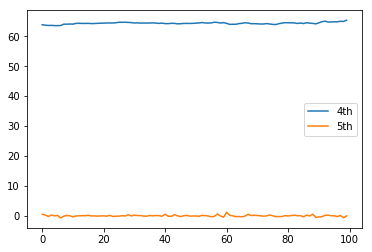

In [208]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
data_path = 'data/financial_data/USD_INR.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# # # Plotting the smartwatch data before scaling/batch normalization
# data[:10000].plot() #x='dteday', y='cnt'

# data[:100].plot()
np.array(data).shape, np.array(data).dtype, np.array(data, dtype=None).dtype, 
# np.array(data[:, 1:], dtype=None).dtype

data = np.array(data)
# plt.plot(data[:100, 1], label='1st')
# plt.plot(data[:100, 2], label='2nd')
# plt.plot(data[:100, 3], label='3rd')
plt.plot(data[:100, 4], label='4th')
plt.plot(data[:100, 5], label='5th')
plt.legend()
plt.show()

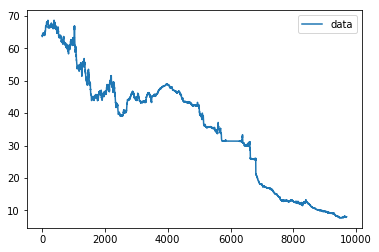

In [209]:
# test_data = np.array([[1, 2, 3]], dtype=float)
# test_data.shape, test_data.dtype
# np.mean(test_data, axis=0), test_data

data_ = np.array(data[:, 1:], dtype=float)
data_.shape, data_.dtype
mean = np.mean(data_, axis=0)
mean.shape
std = np.std(data_, axis=0)
std, data.shape
data_norm = (data_ - mean) / std
data_norm.dtype, data_norm.shape

# plt.plot(data_norm[:1000, 3], label='norm')
plt.plot(data_[:10000, 3], label='data')
plt.legend()
plt.show()

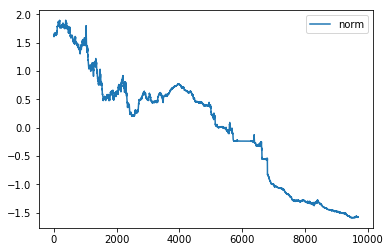

In [210]:
plt.plot(data_norm[:10000, 3], label='norm')
# plt.plot(data_[:1000, 3], label='data')
plt.legend()
plt.show()

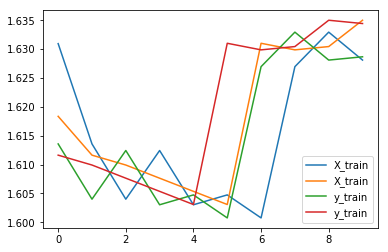

In [211]:
# Sequence learning - seq2seq learning - Unsupervised Learning
# Training
X_train = np.array(data_norm[0:-2]) #, dtype=float)#.reshape(-1, 1)
y_train = np.array(data_norm[1:-1]) #, dtype=float)#.reshape(-1, 1)
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

# # type(X_train[2, 1])
# # X_train.shape
# np.array(X_train).dtype, np.array(X_train, dtype=None).dtype, np.array(X_train, dtype=float).dtype

plt.plot(X_train[:10, 0], label='X_train')

plt.plot(X_train[:10, 1], label='X_train')

plt.plot(y_train[:10, 0], label='y_train')

plt.plot(y_train[:10, 1], label='y_train')

plt.legend()
plt.show()

In [212]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, p_dropout): #, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.p_dropout = p_dropout
        # For text processing
        #         self.idx2char = idx2char
        #         self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m, train): # This can be used for training & testing
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        # Testing
        #         train = None
        #         # train = True
        #         # train = False
        #         if train:
        #             print('1')
        #         else:
        #             print('0')

        if train: # is True
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, do_cache)
        else:
            cache = None

        return y, h, cache

    def backward(self, dy, dh, cache): # This is only used for training
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, do_cache = cache
        
        dh_out = dh.copy()

        dy = l.dropout_backward(dy, do_cache)
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X = X.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
                    
        return ys, caches
    
    def loss_function(self, y_pred, y_train):
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression(y_pred=y, y_train=Y) #/ m: t or number of samples for taking the average
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})

        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
                
        return grads
    
    def test(self, X_seed, h, size):
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
            ys.append(y)
            
        return ys

In [213]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
#     for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            # def loss_function(self, y_pred, y_train):
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini)
            grads = nn.train_backward(dys, caches)            
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)
                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))
                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Validation loss to avoid overfitting & underfitting
        # for idx in range(len(minibatches)):
        idx = len(minibatches)//2
        X_mini, y_mini = minibatches[idx]
        ys = nn.test(X_mini[0], state, size=mb_size)
        valid_loss, _ = nn.loss_function(y_pred=ys, y_train=y_mini)
        nn.losses['valid'].append(valid_loss)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.4f}, valid loss: {:.4f}'.format(iter, loss, valid_loss))

    return nn

Iter-1, train loss: 102.0357, valid loss: 376.4753
Iter-2, train loss: 115.2401, valid loss: 509.0563
Iter-3, train loss: 130.5010, valid loss: 127.2555
Iter-4, train loss: 143.5946, valid loss: 74.1235
Iter-5, train loss: 112.3253, valid loss: 74.4685
Iter-6, train loss: 170.2674, valid loss: 50.7394
Iter-7, train loss: 96.3842, valid loss: 392.6502
Iter-8, train loss: 88.6517, valid loss: 235.4027
Iter-9, train loss: 96.0680, valid loss: 99.1570
Iter-10, train loss: 90.8369, valid loss: 207.5730
Iter-11, train loss: 89.6333, valid loss: 258.1601
Iter-12, train loss: 90.4399, valid loss: 234.2326
Iter-13, train loss: 90.6028, valid loss: 217.7004
Iter-14, train loss: 88.2082, valid loss: 244.3090
Iter-15, train loss: 95.1045, valid loss: 244.8741
Iter-16, train loss: 89.1295, valid loss: 219.3033
Iter-17, train loss: 89.3430, valid loss: 248.3123
Iter-18, train loss: 92.6717, valid loss: 259.3660
Iter-19, train loss: 88.8874, valid loss: 221.2967
Iter-20, train loss: 81.1504, valid lo

Iter-162, train loss: 73.9984, valid loss: 342.7105
Iter-163, train loss: 77.4930, valid loss: 23.3328
Iter-164, train loss: 79.2472, valid loss: 189.7064
Iter-165, train loss: 75.2412, valid loss: 89.7881
Iter-166, train loss: 82.0247, valid loss: 109.3296
Iter-167, train loss: 84.2937, valid loss: 131.3643
Iter-168, train loss: 72.0247, valid loss: 98.0027
Iter-169, train loss: 77.9645, valid loss: 168.2325
Iter-170, train loss: 84.1065, valid loss: 67.1070
Iter-171, train loss: 80.0503, valid loss: 183.8515
Iter-172, train loss: 86.6080, valid loss: 31.9057
Iter-173, train loss: 81.3987, valid loss: 179.3956
Iter-174, train loss: 76.2189, valid loss: 3.2054
Iter-175, train loss: 82.7512, valid loss: 252.1112
Iter-176, train loss: 86.4009, valid loss: 15.2768
Iter-177, train loss: 87.9608, valid loss: 298.6092
Iter-178, train loss: 78.6158, valid loss: 19.5871
Iter-179, train loss: 71.0591, valid loss: 365.5544
Iter-180, train loss: 88.2087, valid loss: 24.8113
Iter-181, train loss: 

Iter-322, train loss: 76.6502, valid loss: 34.6096
Iter-323, train loss: 74.2091, valid loss: 227.0044
Iter-324, train loss: 76.9859, valid loss: 44.0346
Iter-325, train loss: 71.6756, valid loss: 200.1663
Iter-326, train loss: 83.4610, valid loss: 28.6826
Iter-327, train loss: 82.2394, valid loss: 207.5445
Iter-328, train loss: 82.4579, valid loss: 26.2593
Iter-329, train loss: 88.4130, valid loss: 200.2890
Iter-330, train loss: 85.6831, valid loss: 10.7391
Iter-331, train loss: 82.5107, valid loss: 97.3390
Iter-332, train loss: 72.7341, valid loss: 14.0371
Iter-333, train loss: 79.7843, valid loss: 80.4635
Iter-334, train loss: 74.6330, valid loss: 15.1621
Iter-335, train loss: 73.1795, valid loss: 67.1291
Iter-336, train loss: 87.3984, valid loss: 29.4216
Iter-337, train loss: 77.9046, valid loss: 23.4232
Iter-338, train loss: 63.0255, valid loss: 43.8737
Iter-339, train loss: 75.1391, valid loss: 19.3776
Iter-340, train loss: 90.5189, valid loss: 63.3113
Iter-341, train loss: 80.70

Iter-483, train loss: 80.2848, valid loss: 24.7357
Iter-484, train loss: 69.0413, valid loss: 20.5277
Iter-485, train loss: 79.5452, valid loss: 19.7106
Iter-486, train loss: 74.4187, valid loss: 10.4727
Iter-487, train loss: 72.0370, valid loss: 48.8236
Iter-488, train loss: 80.5332, valid loss: 3.8260
Iter-489, train loss: 73.9174, valid loss: 139.8587
Iter-490, train loss: 70.4496, valid loss: 31.5900
Iter-491, train loss: 79.6752, valid loss: 288.0072
Iter-492, train loss: 72.4658, valid loss: 36.2873
Iter-493, train loss: 82.8278, valid loss: 171.1870
Iter-494, train loss: 81.7273, valid loss: 4.5006
Iter-495, train loss: 70.6080, valid loss: 30.5625
Iter-496, train loss: 81.7572, valid loss: 89.1357
Iter-497, train loss: 77.1474, valid loss: 9.4542
Iter-498, train loss: 72.8719, valid loss: 46.3636
Iter-499, train loss: 69.2243, valid loss: 26.8436
Iter-500, train loss: 79.9505, valid loss: 13.2665
Iter-501, train loss: 78.8562, valid loss: 49.3833
Iter-502, train loss: 63.9828, 

Iter-645, train loss: 75.6393, valid loss: 4.0427
Iter-646, train loss: 74.3666, valid loss: 41.8955
Iter-647, train loss: 80.3911, valid loss: 11.0583
Iter-648, train loss: 76.0817, valid loss: 21.0094
Iter-649, train loss: 77.5911, valid loss: 36.6682
Iter-650, train loss: 72.7522, valid loss: 10.6106
Iter-651, train loss: 73.9522, valid loss: 54.1502
Iter-652, train loss: 71.8950, valid loss: 4.7814
Iter-653, train loss: 77.4874, valid loss: 88.4794
Iter-654, train loss: 72.6373, valid loss: 5.2623
Iter-655, train loss: 79.5307, valid loss: 98.1370
Iter-656, train loss: 83.3093, valid loss: 9.7401
Iter-657, train loss: 73.5049, valid loss: 120.9100
Iter-658, train loss: 78.3576, valid loss: 6.5718
Iter-659, train loss: 76.8720, valid loss: 82.8065
Iter-660, train loss: 67.5273, valid loss: 4.1997
Iter-661, train loss: 76.3730, valid loss: 56.4601
Iter-662, train loss: 75.4693, valid loss: 4.2371
Iter-663, train loss: 72.7808, valid loss: 43.3767
Iter-664, train loss: 80.3150, valid 

Iter-807, train loss: 77.0834, valid loss: 7.7471
Iter-808, train loss: 73.2486, valid loss: 69.0470
Iter-809, train loss: 75.2840, valid loss: 5.0441
Iter-810, train loss: 70.0393, valid loss: 46.4349
Iter-811, train loss: 76.1900, valid loss: 4.8827
Iter-812, train loss: 83.6799, valid loss: 39.5775
Iter-813, train loss: 86.1157, valid loss: 5.4392
Iter-814, train loss: 72.4396, valid loss: 22.5438
Iter-815, train loss: 76.8982, valid loss: 14.0411
Iter-816, train loss: 69.4722, valid loss: 12.0273
Iter-817, train loss: 82.3237, valid loss: 30.2019
Iter-818, train loss: 75.0891, valid loss: 5.0676
Iter-819, train loss: 80.5658, valid loss: 48.5205
Iter-820, train loss: 72.6503, valid loss: 4.3141
Iter-821, train loss: 82.9375, valid loss: 59.8422
Iter-822, train loss: 83.1470, valid loss: 6.1776
Iter-823, train loss: 74.0126, valid loss: 64.9772
Iter-824, train loss: 79.2630, valid loss: 9.8629
Iter-825, train loss: 82.2601, valid loss: 70.7250
Iter-826, train loss: 79.0856, valid lo

Iter-970, train loss: 81.9619, valid loss: 55.8990
Iter-971, train loss: 72.5500, valid loss: 6.8705
Iter-972, train loss: 80.8626, valid loss: 36.2046
Iter-973, train loss: 71.2347, valid loss: 3.7138
Iter-974, train loss: 65.1165, valid loss: 20.4481
Iter-975, train loss: 85.1819, valid loss: 4.9446
Iter-976, train loss: 65.0034, valid loss: 11.7349
Iter-977, train loss: 71.6444, valid loss: 5.7653
Iter-978, train loss: 75.7196, valid loss: 8.8318
Iter-979, train loss: 75.2251, valid loss: 7.0735
Iter-980, train loss: 74.7465, valid loss: 6.4336
Iter-981, train loss: 79.6201, valid loss: 10.4299
Iter-982, train loss: 79.6507, valid loss: 4.7015
Iter-983, train loss: 81.7906, valid loss: 16.4273
Iter-984, train loss: 68.7781, valid loss: 3.5957
Iter-985, train loss: 76.7948, valid loss: 32.3229
Iter-986, train loss: 71.9147, valid loss: 8.3802
Iter-987, train loss: 78.7974, valid loss: 63.2998
Iter-988, train loss: 77.8210, valid loss: 12.7074
Iter-989, train loss: 77.7606, valid loss

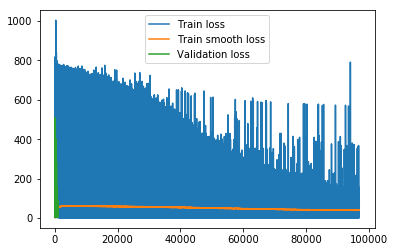

In [214]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = X_train.shape[1] #len(char_to_idx) # vocab_size = len(char_to_idx)
p_dropout = 0.95 # dropout = 1- keep_prob, p = 1-q

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, p_dropout=p_dropout) #, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X_train, y_train=y_train, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

In [207]:
np.random.binomial(1, 0.95, size=X_train.shape[1]) # / p_dropout

array([1, 1, 1, 1, 1])

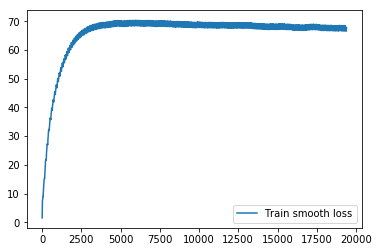

In [120]:
plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

In [40]:
ys = net.test(h=net.initial_state(),size=1000,X_seed=X_train[1000])
np.array(ys).shape

(1000, 1, 2)

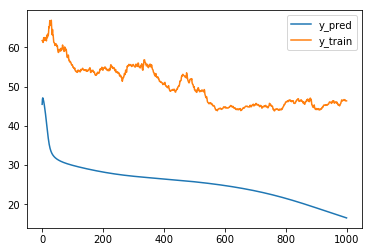

In [41]:
y_pred = np.array(ys).reshape(len(ys), -1)
plt.plot(y_pred[:, 0], label='y_pred')
plt.plot(y_train[1000:2000, 0], label='y_train')
plt.legend()
plt.show()